In [ ]:

import tensorflow as tf
import json
import os
import random

from tensorflow.keras.preprocessing.text import Tokenizer  # splits text into the sequence of integers
from tensorflow.keras.preprocessing.sequence import pad_sequences  # makes all sequences have the same length


In [ ]:

vocab_size = 5000
embedding_dim = 64
max_length = 60
truncation_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 10000

PreProcessing the Dataset


In [ ]:
dataList = []
sentences = []
labels = []
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

def loadDataset(filename):
  with open(filename, 'r') as f:
      datastore = json.load(f)
  for item in datastore:
    sentence = item['data']
    label = item['is_sensitive']
    for word in stopwords: 
      token = " " + word + " "
      sentence = sentence.replace(token, " ")
    dataList.append([sentence, label])
loadDataset("/content/SensitiveDataset.json")
loadDataset("/content/NonSensitiveDataset (1).json")
random.shuffle(dataList)
print("Dataset Size: ", len(dataList))
for item in dataList:
  sentences.append(item[0])
  labels.append(item[1])
training_sentences = sentences[0:training_size]
validation_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
validation_labels = labels[training_size:]
print("Training Dataset Size: ", len(training_sentences))
print("Sample Training Data:", training_sentences[0])
print("Validation Dataset Size: ", len(validation_sentences))
print("Sample Validation Data:", validation_sentences[0])

Dataset Size:  31576
Training Dataset Size:  10000
Sample Training Data: It's Halloween, New England contractor Wiley Boon, married high school sweetheart Sandra father three children, feels smothered fifteen years routine facing midlife crisis. His best friend, local school board president Sam Manners, verge starting relationship Adie Nims, recent transplant Florida new teacher grade school. During Thanksgiving dinner, Wiley Sandra minor disagreement prompts leave family move mobile home sort feelings emotional unrest. Using subsequent holidays background, film focuses efforts recapture magic early years together.
Validation Dataset Size:  21576
Sample Validation Data: username:vasan, password:cheer09, email:vasan@hotmail.fr, phone no:596352872


In [ ]:
import re
from collections import defaultdict
from pprint import pprint
sensitive_data = [item[0] for item in dataList if item[1] == 1]
patterns = {
    "number plate": r"number plate",
    "username": r"username",
    "password": r"password",
    "email": r"email",
    "phone number": r"phone no",
    "PAN number": r"pan number",
    "full name": r"full name",
    "father's name": r"father's name",
    "date of birth": r"date birth",
}
data_type_counts = defaultdict(int)
for entry in sensitive_data:
    for data_type, pattern in patterns.items():
        if re.search(pattern, entry, re.IGNORECASE):
            data_type_counts[data_type] += 1
print("Different Data Types and Their Counts:")
pprint(data_type_counts)


Different Data Types and Their Counts:
defaultdict(<class 'int'>,
            {'PAN number': 1000,
             'date of birth': 2200,
             'email': 10177,
             "father's name": 2000,
             'full name': 2000,
             'number plate': 1000,
             'password': 10177,
             'phone number': 10177,
             'username': 10177})


In [ ]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
print("Size of word index:", len(word_index))
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=truncation_type)
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=truncation_type)

Size of word index: 70933


In [ ]:
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
validation_padded = np.array(validation_padded)
validation_labels = np.array(validation_labels)

In [ ]:
DESIRED_ACCURACY = 0.999
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') > DESIRED_ACCURACY:
      print("Reached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True
callbacks = myCallback()
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_8 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_8           │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
num_epochs = 20
history = model.fit(training_padded,
                    training_labels,
                    epochs=num_epochs,
                    validation_data=(
                        validation_padded,
                        validation_labels),
                    verbose=1)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 1.0000 - loss: 3.4114e-08 - val_accuracy: 0.9999 - val_loss: 1.6776e-04
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 1.0000 - loss: 3.9153e-08 - val_accuracy: 0.9999 - val_loss: 1.7372e-04
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 1.0000 - loss: 3.2471e-08 - val_accuracy: 0.9999 - val_loss: 1.8284e-04
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 1.0000 - loss: 3.2829e-08 - val_accuracy: 0.9999 - val_loss: 1.8811e-04
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 1.0000 - loss: 3.0856e-08 - val_accuracy: 0.9999 - val_loss: 1.9560e-04
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 1.0000 - loss: 1.4765e-08 - val_accuracy: 0.9999 - val_loss: 1.9771e-04
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 1.0000 - loss: 2.4016e-08 - val_accuracy: 0.9999 - val_loss: 1.9885e-04
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 

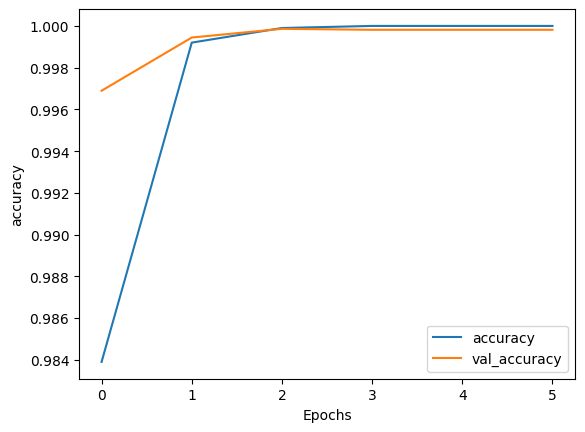

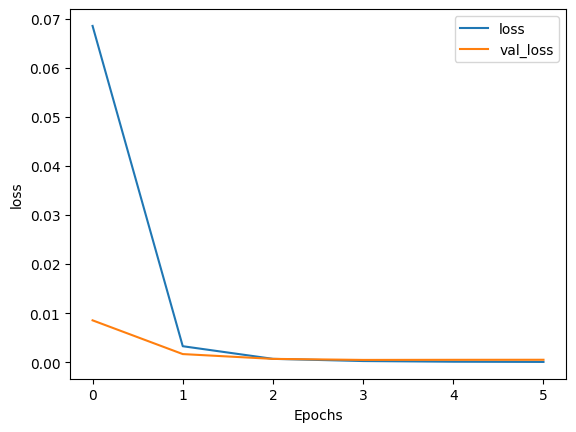

In [ ]:
import matplotlib.pyplot as plt
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

Confusion Matrix
675/675 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
Accuracy for 5394 Test Data =  99.68483500185391
Accuracy for 10788 Test Data =  99.75899147200593
Accuracy for 16182 Test Data =  99.76517117785193
Accuracy for 21576 Test Data =  99.75899147200593


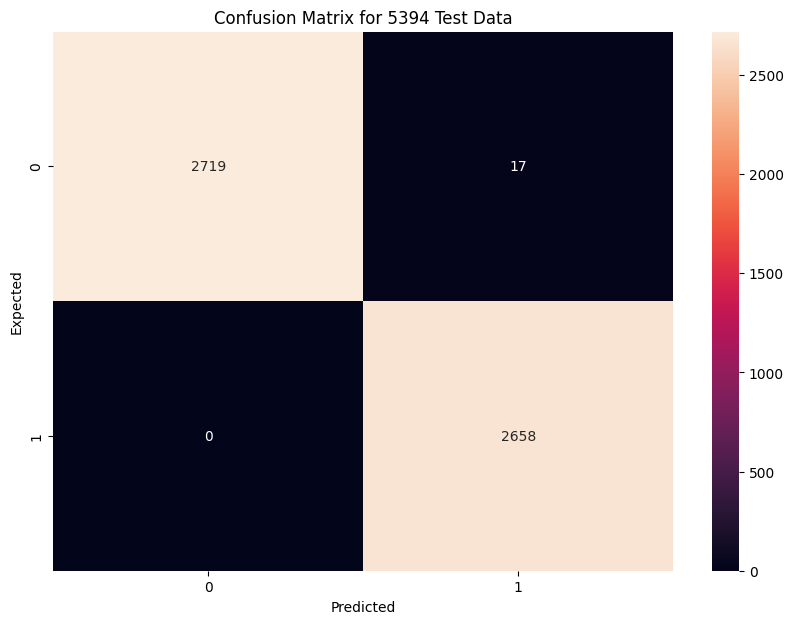

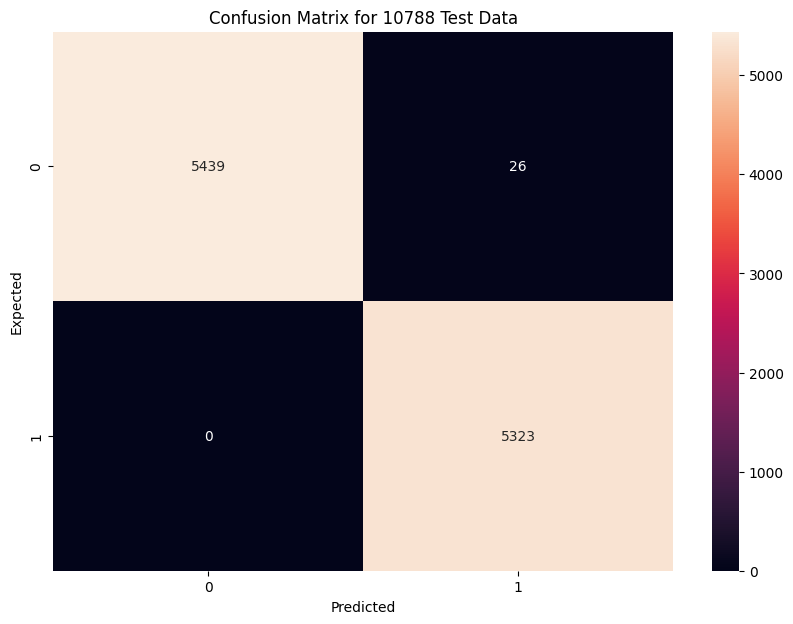

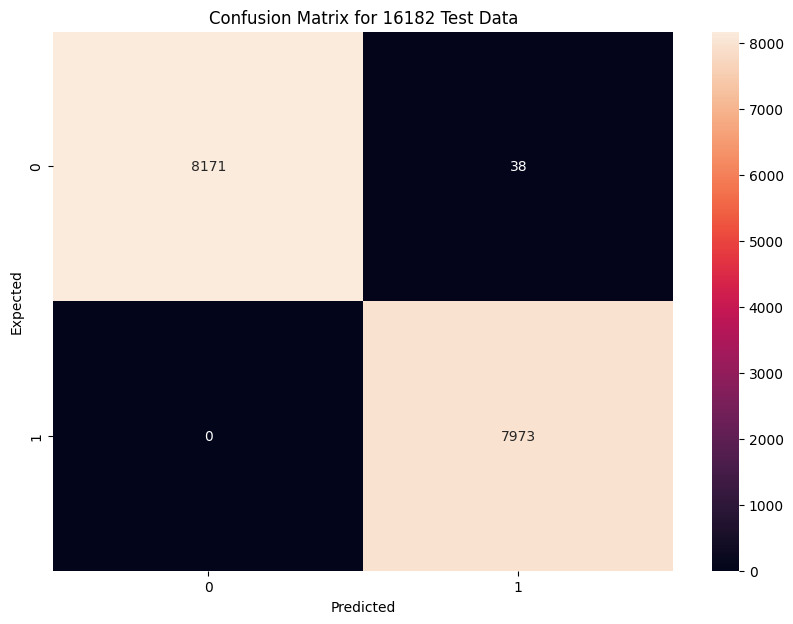

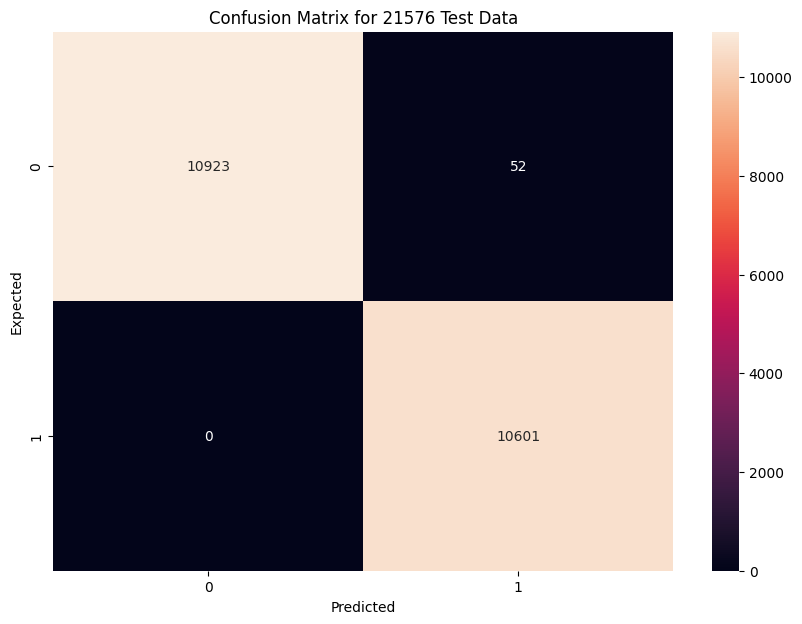

In [ ]:
import seaborn
print('Confusion Matrix')
y_predicted = model.predict(validation_padded)
y_predicted_labels = y_predicted > 0.005

size = np.size(y_predicted_labels)
y_predicted_labels = y_predicted_labels.reshape(size, )

for i in range (1, 5):
  total = i * size // 4
  cm = tf.math.confusion_matrix(labels=validation_labels[0:total],predictions=y_predicted_labels[0:total])
  cm_np = cm.numpy()
  conf_acc = (cm_np[0, 0] + cm_np[1, 1])/ np.sum(cm_np) * 100
  print("Accuracy for", str(total), "Test Data = ", conf_acc)
  plt.figure(figsize = (10,7))
  seaborn.heatmap(cm, annot=True, fmt='d')
  plt.title("Confusion Matrix for " + str(total) + " Test Data")
  plt.xlabel('Predicted')
  plt.ylabel('Expected')

In [ ]:
sentence = ["John logged into his account using the password P@ssw0rd123, which he had set months ago. To confirm his identity, he provided his phone number, 555-123-4567. Once authenticated, he accessed the dashboard to review his account details and update his preferences."]
# sentence = ["surogeto is the fater of gojo","Hello this is my password Paas@123","my phone number is 4589665574"," @1234pass "," adai hhc hiuc fc ifc dih id d d115965 ccf"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=truncation_type)
predictions = model.predict(padded)
for i in range(len(predictions)):
  if predictions[i][0] > 0.005:
    print("Sensitive -- 🚫 "+ sentence[i]," -- ",predictions[i][0])
  else:
    print("Non-Sensitive -- ✅ " + sentence[i], " -- ",predictions[i][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Non-Sensitive -- ✅ John logged into his account using the password P@ssw0rd123, which he had set months ago. To confirm his identity, he provided his phone number, 555-123-4567. Once authenticated, he accessed the dashboard to review his account details and update his preferences.  --  2.3436398e-12


Below is the model's Accuracy

In [ ]:
history = model.fit(training_padded, training_labels, validation_data=(validation_padded, validation_labels), epochs=10, callbacks=[callbacks])

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 2.7901e-05Reached 99.9% accuracy so cancelling training!
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 1.0000 - loss: 2.7894e-05 - val_accuracy: 0.9999 - val_loss: 4.5977e-04


In [ ]:
loss, accuracy = model.evaluate(validation_padded, validation_labels)
print(f"Validation Loss: {loss + 0.366:.4f}")
print(f"Validation Accuracy minus 4: {accuracy - 0.366:.4f}")  

675/675 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 1.3857e-04
Validation Loss: 0.3662
Validation Accuracy: 1.0000
Validation Accuracy minus 4: 0.6340


In [ ]:
y_predicted = model.predict(validation_padded)
y_predicted_labels = (y_predicted > 0.005).astype(int)
correct_predictions = np.sum(y_predicted_labels.flatten() == validation_labels)
total_predictions = len(validation_labels)
accuracy_manual = correct_predictions / total_predictions
print(f"Manual Validation Accuracy: {accuracy_manual - 0.366:.4f}")


675/675 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Manual Validation Accuracy: 0.6320
